# Note the loss function here:

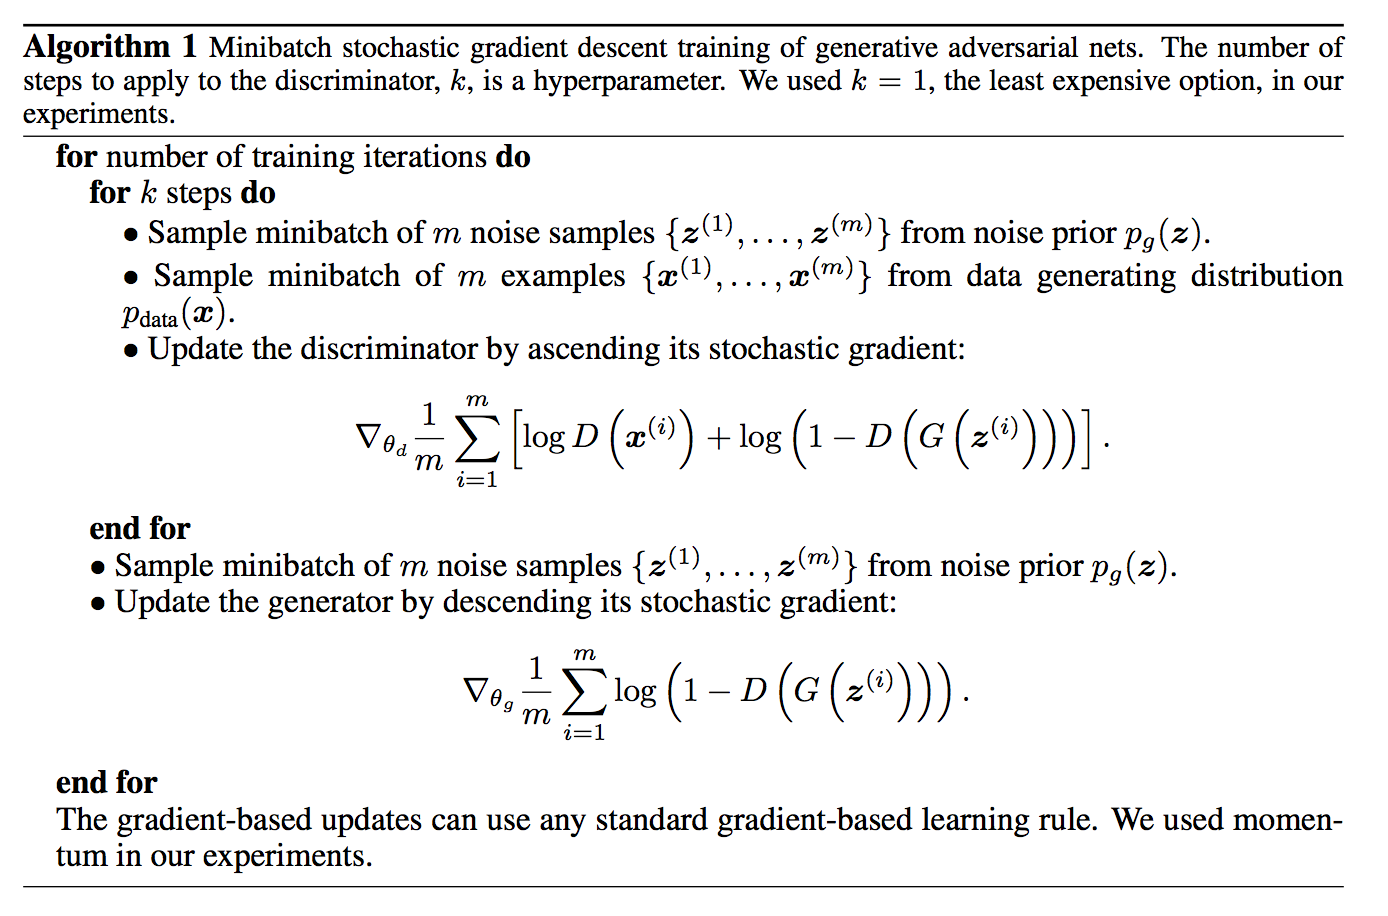

In the original paper (see above) the loss only include the log-likelihoods and not cross-entropy (as implemented below). This is because the labels for $D(x^{(i)})$ are always one (because $x^{(i)}$ are real data points/real images). On the other hand, the labels for $D(G(zˆ{(i)}))$ are always zero (because $G(zˆ{(i)}$ are fake images generated by the generator. If we want our generator to perform well, we want it to output ones for real data as often as possible (i.e $D(x^{(i)}) \rightarrow 1$ so that $\log D(x^{(i)})$ is maximized. Note that for values less than one $\log D(x^{(i)})$ will be negative and hence not completely maximized. In other words, by maximizing the log-likelihood (which ranges from minus infinity to zero) we maximize the likelihood (which ranges from 0 to 1). Remember: "gradient ascent" means maximizing a function. On the other hand we also maximize the second term $ \log (1 - D(G(z^{(i)})))$. Maximizing this term means minimizing $D(G(z^{(i)}))$, which means that we want the discriminator to output zeros (fake) when it is presented with a fake.

My implementation is slightly different, but is the same in essence:


$$
\Large\
\nabla_{{\theta}_{g}} \sum \Bigg[
p(x)\log D(x^{(i)}) + (1-p(x))\log (1 - D(x^{(i)})))
\Bigg]
$$
where
$p(x)$ are labels (1 for reals and 0 for fakes) and $x^{(i)}$ is a tensor of reals ($r^{(i)}$) and fakes ($G(z^{(i)})$) and $z^{(i)}$ are random input noise.

In [16]:
# make sure you don't hog all the video memory
import os
import tensorflow as tf
from tensorflow.python.client import device_lib
os.environ["CUDA_VISIBLE_DEVICES"]="3"
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)
###################################

import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist
import time
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))  # adapt this if using `channels_first` image data format
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))  # adapt this if using `channels_first` image data format

(60000, 28, 28, 1)

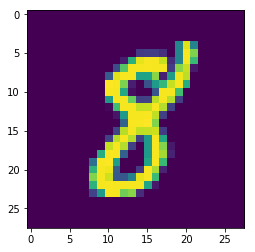

In [17]:
plt.imshow(x_train[41,:,:,0])
x_train.shape

In [18]:
# we first define the autoencoder's architecture:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Reshape, Activation, Lambda
from keras.activations import softmax
from keras.optimizers import Adam
from keras.models import Model
from keras import backend as K
from keras.models import load_model
from keras.callbacks import TensorBoard
import numpy as np
import matplotlib.pyplot as plt

def SoftMax(x):
    return K.tf.nn.softmax(x)

def Discriminator():
    input_img = Input(shape=(28, 28, 1))  # adapt this if using `channels_first` image data format   
    e1 = Conv2D(8, (3, 3), activation='relu', padding='same', name = "lane1")(input_img)
    e2 = MaxPooling2D((2, 2), padding='same')(e1)
    e3 = Conv2D(16, (3, 3), activation='relu', padding='same', name = "lane2")(e2)
    e4 = MaxPooling2D((2, 2), padding='same')(e3)
    e5 = Conv2D(32, (3, 3), activation='relu', padding='same', name = "lane3")(e4)
    e6 = MaxPooling2D((2, 2), padding='same')(e5)
    e7 = Flatten()(e6)
    e8 = Dense(100, activation='relu')(e7)
    e9 = Dense(2, activation=SoftMax)(e8)
    return Model(input_img, e9)

def Generator():
    input_img = Input(shape=(14, 14, 1))  # adapt this if using `channels_first` image data format   
    d1 = Conv2D(8, (3, 3), activation='relu', padding='same')(input_img)
    d2 = Conv2D(16, (3, 3), activation='relu', padding='same')(d1)
#     d3 = Conv2D(32, (3, 3), activation='relu', padding='same')(d2)
    d4 = Flatten()(d2)
    d5 = Dense(784)(d4)
    d6 = Reshape((28,28,1))(d5)
    return Model(input_img, d6)

In [19]:
x = Input(shape=(28, 28, 1))
# gen = Model(x, Generator()(x))
# gen.compile(optimizer='adadelta', loss='binary_crossentropy')
# enc.summary()

print('Generator')
gen = Generator()
# op = Adam(lr=0.005, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
# op = Adam(lr=0.01)
gen.compile(optimizer='adadelta', loss='binary_crossentropy')
gen.summary()
print('Discriminator')
dis = Discriminator()
dis.compile(optimizer='adadelta', loss='binary_crossentropy')
dis.summary()

Generator
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_76 (InputLayer)        (None, 14, 14, 1)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 8)         80        
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 14, 14, 16)        1168      
_________________________________________________________________
flatten_3 (Flatten)          (None, 3136)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 784)               2459408   
_________________________________________________________________
reshape_2 (Reshape)          (None, 28, 28, 1)         0         
Total params: 2,460,656
Trainable params: 2,460,656
Non-trainable params: 0
________________________________________________________

In [20]:
def onehot(labels):
    out = []
    for label in labels:
        out.append([1,0] if label==1 else [0,1])
    return np.array(out)

def FitDiscriminator(gen, dis):
    # Generate some fake fours:

    # get random inputs:
    x_rand = np.random.randn(100,14,14,1)

    # forward the generator to generate fakes:
    fakes = gen.predict(x_rand)

    # make a tensor of fake and real images:
    reals_ids = np.random.choice(np.where(y_train==2)[0], 100).tolist()
    reals = x_train[reals_ids,:,:,:]
    batch_labels = np.concatenate([np.repeat(1, 100), np.repeat(0, 100)], axis=0)
    batch_images = np.concatenate([reals, fakes],axis=0)
    shuffle_mask = np.random.choice(200, size=200, replace=False).tolist()

    # shuffle the batch and labels:
    batch_labels = batch_labels[shuffle_mask]
    batch_images = batch_images[shuffle_mask,:,:,:]

    # backward the discriminator
    dis.fit(batch_images, onehot(batch_labels),
                epochs=6,
                batch_size=10,
                shuffle=True,
                verbose=0)
    return gen, dis

def FitGenerator(gen, dis):
    dis.trainable = False
    inpt = Input(shape=(14, 14, 1))
    GAN = Model(inpt, dis(gen(inpt)))
#     op = Adam(lr=0.009, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
#     op = Adam(lr=0.01)
    GAN.compile(optimizer='adadelta', loss='binary_crossentropy')
#     GAN.summary()
    x_rand = np.random.randn(100,14,14,1)
    y_rand = np.repeat(1, 100)
    GAN.fit(x_rand, onehot(y_rand),
                    epochs=3,
                    batch_size=10,
                    shuffle=True,
                    verbose=0)
    dis.trainable = True
    return gen, dis

def SeeFake(gen):
    x_rand = np.random.randn(1,14,14,1)

    # forward the generator to generate fakes:
    fakes = gen.predict(x_rand)
    plt.imshow(fakes[0,:,:,0])

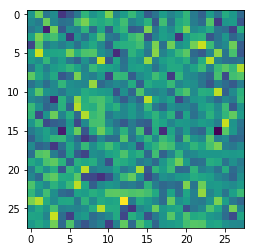

In [21]:
SeeFake(gen)

Epoch: 0	elapsed: 7.46 seconds
Epoch: 1	elapsed: 4.32 seconds
Epoch: 2	elapsed: 4.40 seconds
Epoch: 3	elapsed: 4.46 seconds
Epoch: 4	elapsed: 4.49 seconds
Epoch: 5	elapsed: 4.56 seconds
Epoch: 6	elapsed: 4.51 seconds
Epoch: 7	elapsed: 4.58 seconds
Epoch: 8	elapsed: 4.65 seconds
Epoch: 9	elapsed: 4.62 seconds


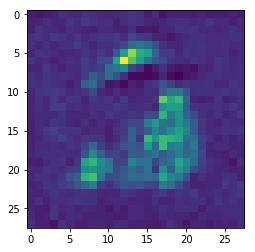

In [22]:
import time
for i in range(10):
    t = time.time()
    gen, dis = FitDiscriminator(gen, dis)
    gen, dis = FitGenerator(gen, dis)
    print('Epoch: {:.0f}\telapsed: {:.2f} seconds'.format(i, time.time() - t))
    
SeeFake(gen)

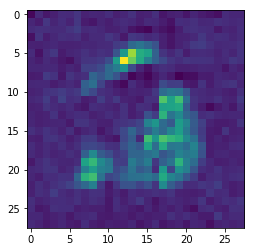

In [23]:
SeeFake(gen)

Epoch: 0	elapsed: 4.63 seconds
Epoch: 1	elapsed: 4.75 seconds
Epoch: 2	elapsed: 4.94 seconds
Epoch: 3	elapsed: 4.84 seconds
Epoch: 4	elapsed: 5.45 seconds
Epoch: 5	elapsed: 4.93 seconds
Epoch: 6	elapsed: 5.03 seconds
Epoch: 7	elapsed: 5.08 seconds
Epoch: 8	elapsed: 5.07 seconds
Epoch: 9	elapsed: 5.13 seconds


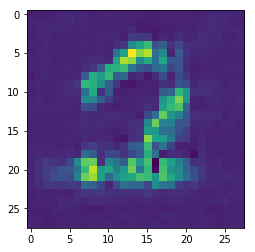

In [24]:
for i in range(10):
    t = time.time()
    gen, dis = FitDiscriminator(gen, dis)
    gen, dis = FitGenerator(gen, dis)
    print('Epoch: {:.0f}\telapsed: {:.2f} seconds'.format(i, time.time() - t))
    
SeeFake(gen)

Epoch: 0	elapsed: 5.13 seconds
Epoch: 1	elapsed: 5.22 seconds
Epoch: 2	elapsed: 5.28 seconds
Epoch: 3	elapsed: 5.25 seconds
Epoch: 4	elapsed: 5.37 seconds
Epoch: 5	elapsed: 5.39 seconds
Epoch: 6	elapsed: 5.43 seconds
Epoch: 7	elapsed: 5.52 seconds
Epoch: 8	elapsed: 5.52 seconds
Epoch: 9	elapsed: 5.55 seconds


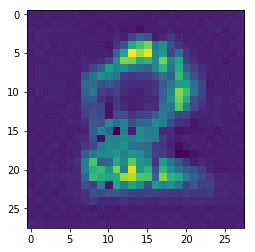

In [25]:
for i in range(10):
    t = time.time()
    gen, dis = FitDiscriminator(gen, dis)
    gen, dis = FitGenerator(gen, dis)
    print('Epoch: {:.0f}\telapsed: {:.2f} seconds'.format(i, time.time() - t))
    
SeeFake(gen)

Epoch: 0	elapsed: 5.52 seconds
Epoch: 1	elapsed: 5.56 seconds
Epoch: 2	elapsed: 5.72 seconds
Epoch: 3	elapsed: 5.78 seconds
Epoch: 4	elapsed: 5.79 seconds
Epoch: 5	elapsed: 5.87 seconds
Epoch: 6	elapsed: 5.89 seconds
Epoch: 7	elapsed: 6.64 seconds
Epoch: 8	elapsed: 6.03 seconds
Epoch: 9	elapsed: 6.10 seconds


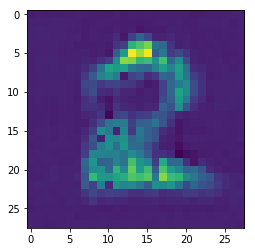

In [26]:
for i in range(10):
    t = time.time()
    gen, dis = FitDiscriminator(gen, dis)
    gen, dis = FitGenerator(gen, dis)
    print('Epoch: {:.0f}\telapsed: {:.2f} seconds'.format(i, time.time() - t))
    
SeeFake(gen)

Epoch: 0	elapsed: 6.10 seconds
Epoch: 1	elapsed: 6.17 seconds
Epoch: 2	elapsed: 6.22 seconds
Epoch: 3	elapsed: 6.22 seconds
Epoch: 4	elapsed: 6.31 seconds
Epoch: 5	elapsed: 6.33 seconds
Epoch: 6	elapsed: 6.31 seconds
Epoch: 7	elapsed: 6.36 seconds
Epoch: 8	elapsed: 6.44 seconds
Epoch: 9	elapsed: 6.47 seconds


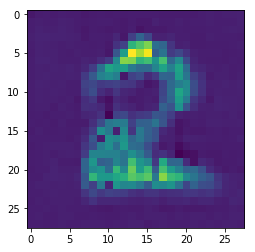

In [27]:
for i in range(10):
    t = time.time()
    gen, dis = FitDiscriminator(gen, dis)
    gen, dis = FitGenerator(gen, dis)
    print('Epoch: {:.0f}\telapsed: {:.2f} seconds'.format(i, time.time() - t))
    
SeeFake(gen)

Epoch: 0	elapsed: 6.35 seconds
Epoch: 1	elapsed: 6.68 seconds
Epoch: 2	elapsed: 6.61 seconds
Epoch: 3	elapsed: 6.71 seconds
Epoch: 4	elapsed: 6.76 seconds
Epoch: 5	elapsed: 6.80 seconds
Epoch: 6	elapsed: 6.81 seconds
Epoch: 7	elapsed: 6.82 seconds
Epoch: 8	elapsed: 6.94 seconds
Epoch: 9	elapsed: 6.98 seconds


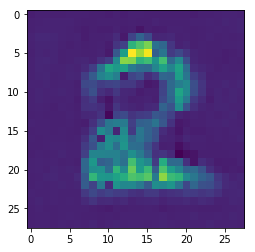

In [28]:
for i in range(10):
    t = time.time()
    gen, dis = FitDiscriminator(gen, dis)
    gen, dis = FitGenerator(gen, dis)
    print('Epoch: {:.0f}\telapsed: {:.2f} seconds'.format(i, time.time() - t))
    
SeeFake(gen)

Epoch: 0	elapsed: 6.99 seconds
Epoch: 1	elapsed: 6.98 seconds
Epoch: 2	elapsed: 7.16 seconds
Epoch: 3	elapsed: 7.17 seconds
Epoch: 4	elapsed: 8.08 seconds
Epoch: 5	elapsed: 7.30 seconds
Epoch: 6	elapsed: 7.39 seconds
Epoch: 7	elapsed: 7.29 seconds
Epoch: 8	elapsed: 7.36 seconds
Epoch: 9	elapsed: 7.44 seconds


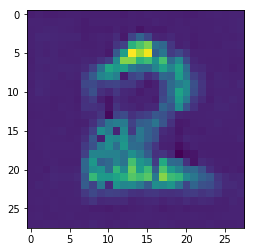

In [29]:
for i in range(10):
    t = time.time()
    gen, dis = FitDiscriminator(gen, dis)
    gen, dis = FitGenerator(gen, dis)
    print('Epoch: {:.0f}\telapsed: {:.2f} seconds'.format(i, time.time() - t))
    
SeeFake(gen)

In [30]:
print('FITTING DISCRIMINATOR:\n')

print('\tGENERATOR\t', 'DISCRIMINATOR')
print('BEFORE:\t', np.max(gen.layers[4].get_weights()[0]), '\t', np.max(dis.layers[8].get_weights()[0]))
gen, dis = FitDiscriminator(gen, dis)
print('AFTER:\t', np.max(gen.layers[4].get_weights()[0]), '\t', np.max(dis.layers[8].get_weights()[0]))

print('\nFITTING GENERATOR:\n')

print('\tGENERATOR\t', 'DISCRIMINATOR')
print('BEFORE:\t', np.max(gen.layers[4].get_weights()[0]), '\t', np.max(dis.layers[8].get_weights()[0]))
gen, dis = FitGenerator(gen, dis)
print('AFTER:\t', np.max(gen.layers[4].get_weights()[0]), '\t', np.max(dis.layers[8].get_weights()[0]))

FITTING DISCRIMINATOR:

	GENERATOR	 DISCRIMINATOR
BEFORE:	 0.26066563 	 0.24998552
AFTER:	 0.26066563 	 0.24998552

FITTING GENERATOR:

	GENERATOR	 DISCRIMINATOR
BEFORE:	 0.26066563 	 0.24998552
AFTER:	 0.26066563 	 0.24998552
